In [1]:
# import needed package
import random
from dataclasses import dataclass
from sample.compute import *
from pathlib import Path
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import *
%matplotlib inline

d:\Anaconda\envs\torch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@dataclass
class PathData:
    # acce in sample
    acce: np.array
    # gyro in sample
    gyro: np.array
    # ahrs in sample
    ahrs: np.array
    # wifi in sample
    wifi: np.array
    # waypoint in sample
    waypoint: np.array


def assmble_path_data(data_lines):
    type_acc = []
    type_gyr = []
    type_rot = []
    type_wif = []
    type_way = []

    data_type_dict = {
        'TYPE_ACCELEROMETER': type_acc,
        'TYPE_GYROSCOPE': type_gyr,
        'TYPE_ROTATION_VECTOR': type_rot,
        'TYPE_WIFI': type_wif,
        'TYPE_WAYPOINT': type_way
    }

    for data_line in data_lines:
        data_line = data_line.strip()

        if data_line[0] == '#' or data_line[0] is None:
            continue

        data_line = data_line.split('\t')

        if not data_type_dict.__contains__(data_line[1]):
            continue

        if data_line[1] == 'TYPE_WIFI':
            ts = data_line[0]
            bssid = data_line[3]
            rssi = data_line[4]
            wifi_data = [ts, bssid, rssi]
            type_wif.append(wifi_data)
            continue

        elif data_line[1] == 'TYPE_WAYPOINT':
            type_way.append([int(data_line[0]), float(data_line[2]), float(data_line[3])])
            continue

        else:
            data_type_dict[data_line[1]].append(
                [int(data_line[0]), float(data_line[2]), float(data_line[3]), float(data_line[4])])
            continue

    type_acc = np.array(type_acc)
    type_gyr = np.array(type_gyr)
    type_rot = np.array(type_rot)
    type_wif = np.array(type_wif)
    type_way = np.array(type_way)

    return PathData(type_acc, type_gyr, type_rot, type_wif, type_way)

In [3]:
def read_path_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    return assmble_path_data(lines)


def combine_wifi_with_position(path_data_files, augmentation=True):
    combined_data = {}
    for path_filename in list(Path(path_data_files).resolve().glob("*.txt")):
        print('Processing file:', path_filename)
        path_data = read_path_data(path_filename)
        acce_data = path_data.acce
        ahrs_data = path_data.ahrs
        wifi_data = path_data.wifi
        waypoint_data = path_data.waypoint

        if augmentation:
            positions = compute_step_positions(acce_data, ahrs_data, waypoint_data)
        else:
            positions = waypoint_data

        if wifi_data.size != 0:
            sep_tss_wifi = np.unique(wifi_data[:, 0].astype(float))
            wifi_data_list = split_ts_seq(wifi_data, sep_tss_wifi)
            for wifi in wifi_data_list:
                diff = np.abs(positions[:, 0] - float(wifi[0, 0]))
                index = np.argmin(diff)
                position_key = tuple(positions[index, 1:3])
                if position_key in combined_data:
                    combined_data[position_key] = np.append(combined_data[position_key], wifi, axis=0)
                else:
                    combined_data[position_key] = wifi


    return combined_data

In [4]:
def extract_wifi_rssi(wifi_data):
    wifi_rssi = {}
    for position_key in wifi_data:
        wifi_ds = wifi_data[position_key]
        for wifi_d in wifi_ds:
            bssid = wifi_d[1]
            rssi = int(wifi_d[2])

            if bssid in wifi_rssi:
                position_rssi = wifi_rssi[bssid]
                if position_key in position_rssi:
                    rssi = position_rssi[position_key][0]
                    wifi_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (rssi * (wifi_count + 1)) / (wifi_count + 1)
                    position_rssi[position_key][1] += 1
                else:
                    position_rssi[position_key] = [rssi, 1]
            else:
                position_rssi = {position_key: [rssi, 1]}

            wifi_rssi[bssid] = position_rssi

    return wifi_rssi

In [5]:
from matplotlib import ticker


def visualize_heatmap(position, value, floor_plan_file, width, height, colorbar_title, save_path, save_name, title=None,
                      show=False):
    # configure
    fig, ax = plt.subplots()
    font_dict = {'fontsize': 14,
                 'fontweight': 8.2,
                 'verticalalignment': 'baseline',
                 'horizontalalignment': 'left'}
    plt.title(title, fontdict=font_dict, loc='left')

    # add floor plan
    img = plt.imread(floor_plan_file)
    ax.imshow(img, extent=(0, width, 0, height))

    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))

    plt.scatter(
        x=position[:, 0],
        y=position[:, 1],
        c=value,
        cmap='gist_rainbow_r',
        s=10
    )
    plt.colorbar(label=colorbar_title, orientation='horizontal')

    plt.savefig(os.path.join(save_path, save_name), format='PNG', dpi=160)

    if show:
        plt.show()

In [6]:
def vis_wifi(site, floor, select_random=True):
    print('Processing wifi rssi on floor', floor, 'in', site)
    file_path = os.path.join('../data/', site, floor)
    floor_info_path = os.path.join(file_path, 'floor_info.json')
    floor_image_path = os.path.join(file_path, 'floor_image.png')

    with open(floor_info_path) as floor_info_file:
        map_info = json.load(floor_info_file)['map_info']

    map_height = map_info['height']
    map_width = map_info['width']

    path_data_files = os.path.join(file_path, 'path_data_files')
    wifi_data = combine_wifi_with_position(path_data_files)
    wifi_rssi = extract_wifi_rssi(wifi_data)
    if select_random:
        for _ in range(0,3):
            target_wifi = random.choice(list(wifi_rssi.keys()))
            print("The chosen wifi ap bssid is:", target_wifi)
            position = np.array(list(wifi_rssi[target_wifi].keys()))
            values = np.array(list(wifi_rssi[target_wifi].values()))[:, 0]
            visualize_heatmap(position, values, floor_image_path, map_width, map_height, colorbar_title='wifi_rssi',
                      save_path='../out/wifi_rssi', save_name=f'{target_wifi.replace(":", "-")}.png',
                      title=f'Wifi: {target_wifi} RSSI', show=True)
    else:
        print('There are 10 example wifi ap bssid:')
        for _ in range(0, 10):
            print(random.choice(list(wifi_rssi.keys())))
        target_wifi = input(f"Please input target wifi ap bssid:\n")
        position = np.array(list(wifi_rssi[target_wifi].keys()))
        values = np.array(list(wifi_rssi[target_wifi].values()))[:, 0]
        visualize_heatmap(position, values, floor_image_path, map_width, map_height, colorbar_title='wifi_rssi',
                      save_path='../out/wifi_rssi', save_name=f'{target_wifi.replace(":", "-")}.png',
                      title=f'Wifi: {target_wifi} RSSI', show=True)

Processing wifi rssi on floor F1 in site1
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd9e7aac5b77e0006b1732b.txt
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd9e7abc5b77e0006b1732d.txt
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd9e7b29191710006b5705b.txt
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd9e7b7c5b77e0006b1732f.txt
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd9e7ba9191710006b5705d.txt
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd9e7bdc5b77e0006b17331.txt
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd9e7bf9191710006b5705f.txt
Processing file: E:\course\urban_computing\assignment\project_1\data\site1\F1\path_data_files\5dd

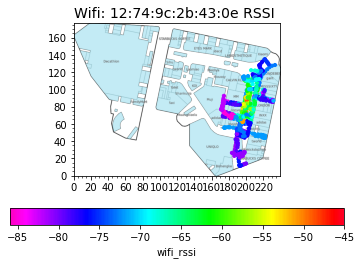

The chosen wifi ap bssid is: 06:05:88:de:0a:af


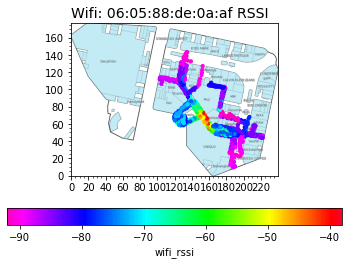

The chosen wifi ap bssid is: 28:23:f5:0d:94:d0


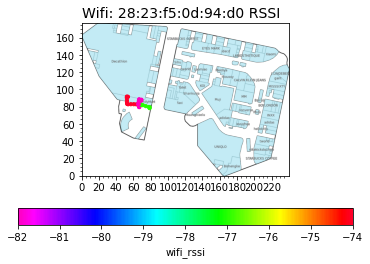

In [7]:
vis_wifi('site1', 'F1', True)